# Modeling
## First method: Decision tree

- **Interpretability:** Decision trees provide a clear and interpretable structure, allowing us to easily understand and communicate the factors influencing MVP votes.

- **Non-linearity Handling:** Captures complex, non-linear relationships in player statistics that may influence MVP voting, offering a more flexible model than linear regression.

- **Feature Importance:** Decision trees inherently rank features based on their importance, aiding in identifying key statistics that significantly impact MVP voting.

- **Handling Non-Normal Distributions:** Decision trees are robust to non-normal distributions in predictor variables, making them suitable for modeling the diverse nature of sports statistics.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor  
from src.PreProcessing import PlayersData, create_clean_dataset_for_test, clean_input_data_for_regression, clean_scale_input_data_for_cnn, apply_eligibilty_criteria
from sklearn.ensemble import RandomForestRegressor
from src.modeling import train_decision_tree, train_cnn, train_random_forest, evaluate_regression_model, evaluate_MVP_classification_from_regression, evaluate_cnn_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
Players_data = PlayersData(path='Data/NBA_Dataset.csv')

print('Shape of raw data: ', Players_data.raw_data.shape)

Players_data.raw_data.head()

Shape of raw data:  (17697, 55)


,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768


In [3]:
print('Shape of data with eligible players: ', Players_data.eligible_players_data.shape)

Players_data.eligible_players_data.head()

Shape of data with eligible players:  (1700, 56)


,index,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,...,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,0,1982,Kareem Abdul-Jabbar,0,34,LAL,76,76,35.2,9.9,...,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,1,1982,Alvan Adams,0,27,PHO,79,75,30.3,6.4,...,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561
2,8,1982,Greg Ballard,1,27,WSB,79,79,37.3,7.9,...,9.4,0.154,1.5,1.7,3.2,3.9,0.000,0.88,1.06,0.524
3,14,1982,Larry Bird,2,25,BOS,77,58,38.0,9.2,...,12.5,0.205,4.4,2.3,6.6,6.4,0.588,6.38,6.35,0.768
4,60,1982,Adrian Dantley,1,26,UTA,81,81,39.8,11.2,...,12.6,0.187,5.8,-1.7,4.1,5.0,0.010,-5.66,-5.63,0.305


<Axes: title={'center': 'Missing map'}>

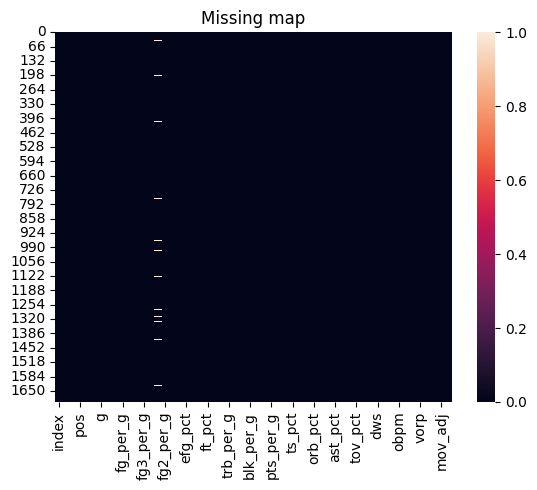

In [4]:
plt.title('Missing map')
sns.heatmap(Players_data.eligible_players_data.isnull())

**Nan values**

Some players have Nan values their average percentage for some very specific shots: maybe they did not got the opportunity to take them or maybe they just never take them. But we cannot put 0 to try not to bias the selection and putting the mean will also advantage two much one player also. So we will use KNN algorithm to try to fill the values by looking at neighboors.

**Encoding**

We are not going to keep the team of the player because we want our system to be the fairest and not be biased by external factors like the attrcativity of a team, or the size of the team's market.
So the only categorical variable left at the end his the position so since we are working on a Decision tree, we used label encoding rather than one hot encoding.

**Scaling**

No scaling is needed for the preprocessing of a decision tree.

**Splitting the dataset**

We will randomly select 5 season including 2022 to test our model on the most recent on the database and that also brought a lot of debates.

In [5]:
X_train_reg, y_train_reg, X_test_reg, y_test_reg, years_selected_for_test, imputer,_,df_train  = Players_data.get_splitted_data_for_regression(year_test_regression=np.array([2019,1985,2009,2011,2022]))

print('years selected to test our model :', years_selected_for_test)

years selected to test our model : [2019 1985 2009 2011 2022]


### Grid search of the best parameters

In [6]:
# Define the Decision Tree regressor
dt_regressor = DecisionTreeRegressor()

# Define the parameter grid to search
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(dt_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_reg, y_train_reg)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [7]:
model_decision_tree = train_decision_tree(
    X_train=X_train_reg,
    y_train=y_train_reg,
    **grid_search.best_params_
)

Training Mean Absolute Error: 0.033574682764579165
Training Mean Squarred Error: 0.006378288871737745
Training R2 score: 0.8073166399040675


In [8]:
df_of_result = evaluate_regression_model(model_decision_tree, X_test_reg, y_test_reg, name='Decision Tree')
df_of_result.head()

Mean Absolute Error: 0.04754813364247876
Mean Squarred Error: 0.0143941811063407
R2 score: 0.5594106844941574


,MSE,MAE,R2 Score
Decision Tree,0.014394,0.047548,0.559411


In [9]:
print('Testing at predicting the NBA MVP for the 5 test years selected with Decision Tree')
df_with_result_mvp = evaluate_MVP_classification_from_regression(model_decision_tree, X_test_reg, df_train, 'decision tree','mvp_classificatioon_by_decsion_tree.txt')

Testing at predicting the NBA MVP for the 5 test years selected with Decision Tree
MVP Classifaction measured Accuracy :  60.0 %


## Random forest

- **Ensemble Learning:** Random Forest combines multiple decision trees to improve overall predictive accuracy and generalization.

- **Robust to Overfitting:** Aggregation of trees helps mitigate overfitting, providing a more robust model for MVP prediction.

- **Feature Importance:** Automatically ranks features, aiding in the identification of crucial statistics for determining MVP status.

- **Non-linearity Handling:** Flexible enough to capture non-linear relationships in player statistics, offering superior performance to linear models.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_reg, y_train_reg)

print(rf_random.best_params_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [12]:
model_random_forest = train_random_forest(X_train_reg,y_train_reg, **rf_random.best_params_)

Training Mean Absolute Error: 0.006684526221021833
Training Mean Squarred Error: 0.000347957395678596
Training R2 score: 0.9894884660262627


In [13]:
df_of_result = evaluate_regression_model(model_random_forest, X_test_reg, y_test_reg, df_of_result, name='Random Forest')
df_of_result.head()

Mean Absolute Error: 0.03648162671232878
Mean Squarred Error: 0.00772914260511717
R2 score: 0.7634198413457828


,MSE,MAE,R2 Score
Random Forest,0.007729,0.036482,0.763420
Decision Tree,0.014394,0.047548,0.559411


In [14]:
print('Testing at predicting the NBA MVP for the 5 test years selected with Random Forest')
df_with_result_mvp = evaluate_MVP_classification_from_regression(model_random_forest, X_test_reg, df_train, 'Random Forest','mvp_classificatioon_by_decsion_tree.txt')

Testing at predicting the NBA MVP for the 5 test years selected with Random Forest
MVP Classifaction measured Accuracy :  80.0 %


# CNN

- **Image-like Data Handling:** CNNs excel in processing grid-like data, making them suitable for analyzing patterns in structured player statistics.

- **Hierarchical Feature Learning:** CNNs automatically learn hierarchical representations, allowing the model to capture complex relationships within the data.

- **Spatial Relationships:** Effective in capturing spatial relationships between different statistics, providing insights into how various metrics interact.

- **Transfer Learning Opportunities:** Pre-trained CNN models can be leveraged, especially if there's a shortage of labeled MVP data, allowing for better model generalization.


In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y, X_test, y_test, players_list_train, players_list_test,  years_for_test, nan_imputer, scaler_dl, onehotencoder = Players_data.get_splitted_data_for_dl(years_for_test=years_selected_for_test, multiplier_of_data=30)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
num_features = X_train.shape[2]
num_players = 10

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(3,num_features-2), activation='relu', input_shape=(num_players, num_features, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_players, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), verbose=0)

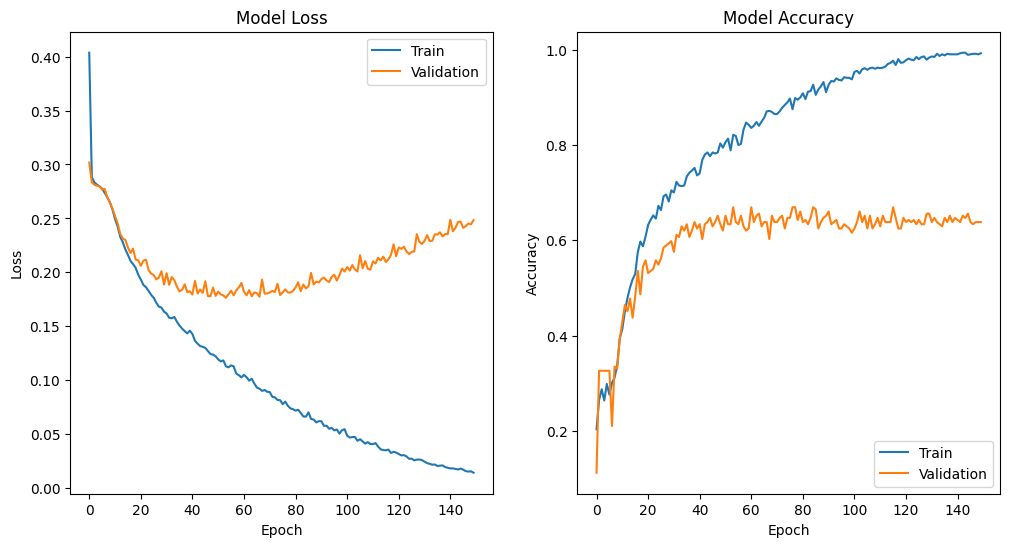

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

70 epochs seems well enough and good pooint to avoid overfitting.

In [18]:
model_cnn = train_cnn(X, y, num_epochs=60, verbose = 0)

train_loss, train_accuracy = model_cnn.evaluate(X_train, y_train)
val_loss, val_accuracy = model_cnn.evaluate(X_val, y_val)
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
print(f'Train --  Accuracy: {train_accuracy}, Loss: {train_loss}')
print(f'Validation --  Accuracy: {val_accuracy}, Loss: {val_loss}')
print(f'Test --  Accuracy: {test_accuracy}, Loss: {test_loss}')

5/5 [==============================] - 0s 1ms/step - loss: 0.1758 - accuracy: 0.6516
Train --  Accuracy: 0.8284753561019897, Loss: 0.1152355745434761
Validation --  Accuracy: 0.8214285969734192, Loss: 0.11702845990657806
Test --  Accuracy: 0.6516128778457642, Loss: 0.17584164440631866


In [19]:
X_train.shape

(892, 10, 56, 1)

In [20]:
print('Testing at predicting the NBA MVP for the 5 test years selected with CNN')
y_pred, evaluation_results = evaluate_cnn_model(model_cnn,  X_test, y_test, players_list_test, df_of_result, 'output/output_cnn.txt', 'CNN')

Testing at predicting the NBA MVP for the 5 test years selected with CNN
5/5 [==============================] - 0s 1ms/step
MVP Classification Accuracy :
Accuracy: 65.359%



In [21]:
evaluation_results

,MSE,MAE,R2 Score
CNN,0.053080,0.096192,0.219829
Random Forest,0.007729,0.036482,0.763420
Decision Tree,0.014394,0.047548,0.559411


# Predicting 2023-24 NBA MVP

Now that all model have been trained will put them in application using today stats gathered from Basketball reference.

In [22]:
from src.get_data_online import BaskRefPlayerDataScraper
from src.PreProcessing import create_clean_dataset_for_test

print('\n ----- Scrape Players stats from basketball-reference.com -----\n ')
player_data_scraper = BaskRefPlayerDataScraper()
game_data = player_data_scraper.scrape_table_data(
    "https://www.basketball-reference.com/leagues/NBA_2024_per_game.html#per_game_stats", 
    'div_per_game_stats', 
    'full_table')

advanced_data = player_data_scraper.scrape_table_data(
    'https://www.basketball-reference.com/leagues/NBA_2024_advanced.html', 
    'div_advanced_stats', 
    'full_table')

team_data = player_data_scraper.scrape_table_data(
    'https://www.basketball-reference.com/leagues/NBA_2024_ratings.html', 
    'div_ratings')

df2023 = create_clean_dataset_for_test(
    game_data, 
    advanced_data, 
    team_data, 
    path_to_aggragation_team_json = 'Data/external/teams_abbreviation.json',
    code_for_position = Players_data.dict_pos_factorize
    )

df2023.head()


 ----- Scrape Players stats from basketball-reference.com -----
 


,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
0,Precious Achiuwa,2,24.0,TOT,73.0,20.0,22.7,3.4,6.7,0.509,...,2.343920,3.906534,0.111,-1.4,0.4,-1.0,0.4,NaN,NaN,NaN
1,Bam Adebayo,0,26.0,MIA,69.0,69.0,34.3,7.6,14.7,0.521,...,4.268493,7.076712,0.143,0.9,1.7,2.6,2.5,1.22,0.69,0.548
2,Ochai Agbaji,3,23.0,TOT,80.0,25.0,20.2,2.3,5.5,0.414,...,0.669691,0.334846,0.009,-3.3,-0.9,-4.2,-0.8,NaN,NaN,NaN
3,Santi Aldama,2,23.0,MEM,67.0,38.0,26.6,4.1,9.4,0.435,...,2.246575,2.583562,0.069,-0.7,0.4,-0.2,0.7,-6.97,-6.37,0.329
4,Nickeil Alexander-Walker,3,25.0,MIN,82.0,21.0,23.6,2.8,6.4,0.432,...,2.920548,4.156164,0.105,-1.3,1.5,0.2,0.9,6.82,6.82,0.699


In [23]:
X_2023_regression = clean_input_data_for_regression(df2023, imputer)
X_2023_cnn, player_D = clean_scale_input_data_for_cnn(df2023, nan_imputer, scaler_dl, onehotencoder, multiplier_of_data=2500)

In [24]:
test_2023 = model_cnn.predict(X_2023_cnn)

resultssss = {}
for num, pred in enumerate(test_2023):
    index_of_predicted = np.argmax(pred)
    player = player_D[num][index_of_predicted]["player"]
    resultssss.setdefault(player,0)
    resultssss[player] = resultssss.get(player,0) + 1
    
sorted_MVPS = dict(sorted(resultssss.items(), key=lambda item:item[1], 
reverse=True))
print('Testing at predicting the NBA MVP for the 2023-24 NBA season with CNN')
print({k: sorted_MVPS[k] for k in list(sorted_MVPS.keys())[:5]})

79/79 [==============================] - 0s 2ms/step
Testing at predicting the NBA MVP for the 2023-24 NBA season with CNN
{'Nikola Jokić': 379, 'Shai Gilgeous-Alexander': 324, 'Luka Dončić': 256, 'Giannis Antetokounmpo': 254, 'Domantas Sabonis': 165}


In [25]:
df2023.head()
y_pred_dt = model_decision_tree.predict(X_2023_regression)
y_pred_rf = model_random_forest.predict(X_2023_regression)

df_2023_eligible_players = apply_eligibilty_criteria(df2023)
df_2023_eligible_players['decision tree'] = y_pred_dt
df_2023_eligible_players['random forest'] = y_pred_rf

print('Testing at predicting the NBA MVP for the 2023-24 NBA season with decision tree :')
df_2023_eligible_players.sort_values(by=['decision tree'], ascending=False)[['player','decision tree']].head(5)

Testing at predicting the NBA MVP for the 2023-24 NBA season with decision tree :


,player,decision tree
24,Nikola Jokić,0.685615
11,Luka Dončić,0.275200
17,Shai Gilgeous-Alexander,0.246750
2,Giannis Antetokounmpo,0.154717
25,Kawhi Leonard,0.039835


In [26]:
print('Testing at predicting the NBA MVP for the 2023-24 NBA season with random forest :')
df_2023_eligible_players.sort_values(by=['random forest'], ascending=False)[['player','random forest']].head(5)

Testing at predicting the NBA MVP for the 2023-24 NBA season with random forest :


,player,random forest
24,Nikola Jokić,0.813827
17,Shai Gilgeous-Alexander,0.665498
11,Luka Dončić,0.419642
2,Giannis Antetokounmpo,0.390422
38,Jayson Tatum,0.165499
